In [13]:
import sys
sys.path.append('../')
import corecomposition as cc

import numpy as np
import pyvo as vo
import pickle
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

In [14]:
gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

In [15]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id'])
bronze = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id')


In [16]:
source_ids = bronze['wd_source_id']
coords = [SkyCoord(frame="galactic", l=bronze['wd_l'][i]*u.deg, b=bronze['wd_b'][i]*u.deg, distance = bronze['distance'][i] * u.pc) for i in range(len(bronze))]
astrometric_params = bronze['wd_astrometric_params_solved']
photo = np.array([bronze['wd_phot_g_mean_mag'], bronze['wd_phot_bp_mean_mag'], bronze['wd_phot_rp_mean_mag']]).T
e_photo = np.array([bronze['wd_e_gmag'], bronze['wd_e_bpmag'], bronze['wd_e_rpmag']]).T
initial_params = np.array([bronze['CO_Hdef_teff'], bronze['CO_Hdef_radius']]).T

In [17]:
from dustmaps.edenhofer2023 import Edenhofer2023Query
bsq = Edenhofer2023Query()

Optimizing map for querying (this might take a couple of seconds)...


In [ ]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params, bsq = bsq)

100%|██████████| 26/26 [00:01<00:00, 17.30it/s]


In [ ]:
# 20.463974  
obj.photometry[0]

array([20.46395524, 20.26533889, 20.02453061, 20.49467261, 20.36938103,
       20.01028564, 19.78758849])

In [ ]:
co_hdef_chains = obj.run_mcmc(cc.interpolator.LaPlataUltramassive, core='CO', layer='Hdef')

with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'wb') as f:
    pickle.dump(co_hdef_chains, f)

  0%|          | 0/26 [00:00<?, ?it/s]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [74.7728849  73.43914296]


Auto-Correlation Time = 74.7728849025037, additional steps = 1388


  4%|▍         | 1/26 [03:22<1:24:29, 202.78s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [100.21123251 110.93346468]


Auto-Correlation Time = 110.93346467916929, additional steps = 3268


  8%|▊         | 2/26 [07:24<1:30:19, 225.81s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [72.59506445 72.17514445]


Auto-Correlation Time = 72.59506445141685, additional steps = 1274


 12%|█▏        | 3/26 [09:42<1:11:08, 185.58s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [115.14462766 124.02540486]


Auto-Correlation Time = 124.02540485912353, additional steps = 3949


 15%|█▌        | 4/26 [14:03<1:19:02, 215.55s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [79.47022708 86.95268431]


Auto-Correlation Time = 86.95268430526662, additional steps = 2021


 19%|█▉        | 5/26 [17:55<1:17:29, 221.42s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [327.21000474 325.94406908]


Auto-Correlation Time = 327.21000473665526, additional steps = 14514


 23%|██▎       | 6/26 [26:42<1:48:24, 325.22s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [57.49617363 56.6362455 ]


Auto-Correlation Time = 57.496173626581665, additional steps = 489


 27%|██▋       | 7/26 [29:02<1:23:50, 264.77s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [76.40418019 75.51310017]


Auto-Correlation Time = 76.4041801948612, additional steps = 1473


 35%|███▍      | 9/26 [34:15<57:57, 204.58s/it]  

Auto-Correlation Time = 35.974755161438765, additional steps = -630


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [ 95.97844555 100.38147084]


Auto-Correlation Time = 100.3814708381289, additional steps = 2719


 38%|███▊      | 10/26 [38:42<59:42, 223.90s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [78.64361886 81.62072069]


Auto-Correlation Time = 81.62072069412682, additional steps = 1744


 42%|████▏     | 11/26 [41:39<52:21, 209.43s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [155.04712895 183.41889233]


Auto-Correlation Time = 183.41889233309428, additional steps = 7037


 46%|████▌     | 12/26 [47:37<59:26, 254.72s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [109.97647642 112.76292117]


Auto-Correlation Time = 112.76292116835684, additional steps = 3363


 50%|█████     | 13/26 [52:17<56:51, 262.40s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [182.85900349 186.9534793 ]


Auto-Correlation Time = 186.95347930342322, additional steps = 7221


 54%|█████▍    | 14/26 [58:34<59:23, 296.98s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [123.86063402 131.36627419]


Auto-Correlation Time = 131.3662741916402, additional steps = 4331


 58%|█████▊    | 15/26 [1:02:49<52:05, 284.17s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [104.07350223 127.4525503 ]


Auto-Correlation Time = 127.45255029876992, additional steps = 4127


 62%|██████▏   | 16/26 [1:05:19<40:37, 243.77s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [ 87.07523594 106.64994944]


Auto-Correlation Time = 106.64994943910347, additional steps = 3045


 65%|██████▌   | 17/26 [1:08:41<34:40, 231.21s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [152.56680365 157.09956618]


Auto-Correlation Time = 157.0995661810973, additional steps = 5669


 69%|██████▉   | 18/26 [1:13:08<32:17, 242.16s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [52.44393143 52.15308742]


Auto-Correlation Time = 52.44393143219084, additional steps = 227


 77%|███████▋  | 20/26 [1:15:20<15:13, 152.21s/it]

Auto-Correlation Time = 35.62969953179612, additional steps = -648


 81%|████████  | 21/26 [1:16:31<10:38, 127.79s/it]

Auto-Correlation Time = 41.79016442552987, additional steps = -327


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [275.7530432  276.86671164]


Auto-Correlation Time = 276.8667116421401, additional steps = 11897


 85%|████████▍ | 22/26 [1:21:08<11:29, 172.45s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [100.36901641 109.02078867]


Auto-Correlation Time = 109.02078867203392, additional steps = 3169


 88%|████████▊ | 23/26 [1:24:34<09:08, 182.76s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [63.91602454 66.58826455]


Auto-Correlation Time = 66.58826455346885, additional steps = 962


 92%|█████████▏| 24/26 [1:26:13<05:14, 157.37s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [77.5277487  84.82277323]


Auto-Correlation Time = 84.82277323332026, additional steps = 1910


 96%|█████████▌| 25/26 [1:28:50<02:37, 157.42s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [305.01575789 331.89529871]


Auto-Correlation Time = 331.8952987073777, additional steps = 14758


100%|██████████| 26/26 [1:34:54<00:00, 219.03s/it]


NameError: name 'pickle' is not defined

In [ ]:
with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'wb') as f:
    pickle.dump(co_hdef_chains, f)

{1307515077152381568: array([[7.31814029e+03, 8.41257861e-03],
        [7.23590642e+03, 8.58676962e-03],
        [7.32269414e+03, 8.40855253e-03],
        ...,
        [7.39001494e+03, 8.28550440e-03],
        [7.39783064e+03, 8.28663291e-03],
        [7.26366313e+03, 8.49083610e-03]]),
 1424062412046712576: array([[9.24143023e+03, 9.63322568e-03],
        [9.02693052e+03, 9.82993195e-03],
        [9.33030984e+03, 9.41895203e-03],
        ...,
        [9.12302234e+03, 9.75486842e-03],
        [9.33162115e+03, 9.43665326e-03],
        [9.10683343e+03, 9.74186038e-03]]),
 1699104219238181248: array([[1.44143378e+04, 4.50735721e-03],
        [1.55356319e+04, 4.17222921e-03],
        [1.43824743e+04, 4.52688319e-03],
        ...,
        [1.37676250e+04, 4.72137325e-03],
        [1.45391481e+04, 4.46462930e-03],
        [1.54198824e+04, 4.22028266e-03]]),
 1792836069385045760: array([[1.21976644e+04, 5.07546693e-03],
        [1.08120899e+04, 5.87135671e-03],
        [1.19195904e+04, 5.2148

In [ ]:
co_hrich_chains = obj.run_mcmc(cc.interpolator.LaPlataUltramassive, core='CO', layer='Hrich')

with open('../data/cleaned/radius_chains_CO_Hrich.pkl', 'wb') as f:
    pickle.dump(co_hrich_chains, f)

  0%|          | 0/26 [00:00<?, ?it/s]

emcee: Exception while calling your likelihood function:
  params: [9.68703316e+03 5.57340180e-03]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/arsen/research/proj/core-composition/notebooks/../corecomposition/interpolator/fit.py", line 166, in log_prob
    ll = log_likelihood(params)
         ^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/arsen/research/proj/core-composition/notebooks/../corecomposition/interpolator/fit.py", line 153, in log_likelihood
    flux_model =  self.get_model_flux(params) # compute model fluxes
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/arsen/research/proj/core-composition/notebooks/../corecomposition/interpolator/fit.py", line 138, in get_model_flux
    fl= 4 * np.pi * self.interpolator(params[0], 9) # flux in physical units
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/arsen/research/proj/core-compositio

emcee: Exception while calling your likelihood function:
  params: [5.64057530e+03 1.26460382e-02]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
one_hrich_chains = obj.run_mcmc(cc.interpolator.LaPlataUltramassive, core='ONe', layer='Hrich')

with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'wb') as f:
    pickle.dump(one_hrich_chains, f)

In [ ]:
one_hdef_chains = obj.run_mcmc(cc.interpolator.LaPlataUltramassive, core='ONe', layer='Hdef')

with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'wb') as f:
    pickle.dump(one_hdef_chains, f)

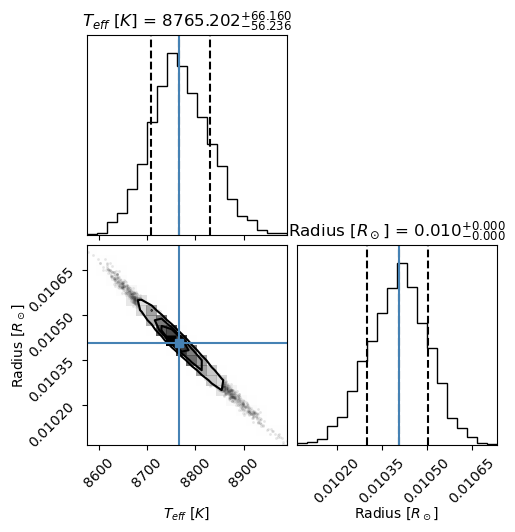

In [ ]:
import corner

id = list(co_hdef_chains.keys())[10]

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(co_hdef_chains[id][:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(co_hdef_chains[id], labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

In [ ]:
gold_coverage = join(gold, table, keys_left='wd_source_id', keys_right='source_id')
silver_coverage = join(silver, table, keys_left='wd_source_id', keys_right='source_id')
bronze_coverage = table

print(f'gold coverage = {len(gold_coverage)} / {len(gold)}')
print(f'silver coverage = {len(silver_coverage)} / {len(silver)}')
print(f'bronze coverage = {len(bronze_coverage)} / {len(bronze)}')